### Finetuning Geneformer to classify PD and normal control cells
The geneformer architecture requires a GPU to run, so this notebook was mounted in a Google colab notebook to have access to a GPU. 

In [1]:
import datetime

import pickle
import pandas as pd
import matplotlib.pyplot as plt

from geneformer import Classifier

/Users/erykkropiwnicki/.pyenv/versions/retrobio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

In [4]:
output_prefix = "pd_classifier"
output_dir = "pd_classifier"
!mkdir $output_dir

In [5]:
# Because of limited time and resources I will use the hyperparameters
# found by the authors to perform well on a comparable fine-tuning task
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_status",
                                    "states": ["Parkinson disease","normal"]},
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=200,
                nproc=16)

### Split donor samples into train, eval, and test sets

In [ ]:
train_ids = ["3482","3346","3873","5610","3322","3345","4956",
             "4560","4568","2142"]
eval_ids = ["6173","3887"]
test_ids = ["3298","1963"]

train_test_id_split_dict = {"attr_key": "donor_id",
                            "train": train_ids+eval_ids,
                            "test": test_ids}

cc.prepare_data(
    input_data_file="PD_data/PD.dataset",
    output_directory=output_dir,
    output_prefix=output_prefix,
    split_id_dict=train_test_id_split_dict
)

### Run cross-validation and output model artifacts to directory

In [7]:
train_valid_id_split_dict = {"attr_key": "donor_id",
                            "train": train_ids,
                            "eval": eval_ids}
all_metrics = cc.validate(model_directory="Geneformer/",
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Geneformer/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/content/Geneformer/geneformer/collator_for_classification.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.025500,1.181987,0.821723,0.814060


/content/Geneformer/geneformer/collator_for_classification.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


  0%|          | 0/65 [00:00<?, ?it/s]

### Model Evaluation

In [7]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_status", "states": ["Parkinson disease","normal"]},
                forward_batch_size=200,
                nproc=16)

In [12]:
# This function runs evaluation of the saved model on the test set
# and outputs evaluation metrics to pkl files
all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
        id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
        test_data_file=f"{output_dir}/{output_prefix}_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/84 [00:00<?, ?it/s]

### Look at metrics to get broad view of model performance

In [10]:
# Read in predictions
file_path = f"{output_dir}/pd_classifier_pred_dict.pkl"

with open(file_path, 'rb') as file:
    pred_dict = pickle.load(file)

# Read in test metrics
file_path = f"{output_dir}/pd_classifier_test_metrics_dict.pkl"

with open(file_path, 'rb') as file:
    metrics_dict = pickle.load(file)

In [11]:
pred_dict.keys()

dict_keys(['pred_ids', 'label_ids', 'predictions'])

In [13]:
y_true, y_pred = pred_dict['label_ids'], pred_dict['pred_ids']

In [5]:
metrics_dict.keys()

dict_keys(['conf_matrix', 'macro_f1', 'acc', 'all_roc_metrics'])

### AUROC

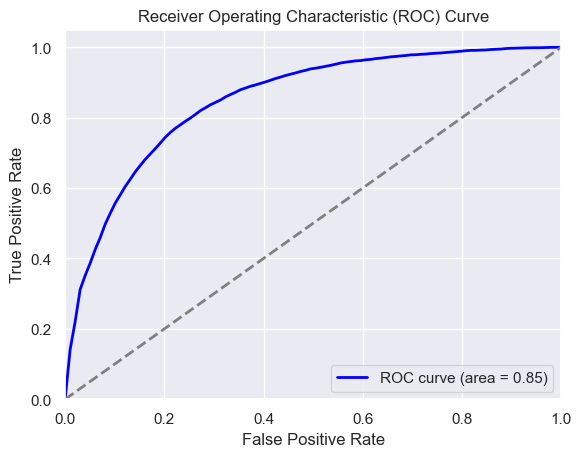

In [8]:
mean_fpr, mean_tpr, roc_auc = metrics_dict['all_roc_metrics']['mean_fpr'], \
                     metrics_dict['all_roc_metrics']['mean_tpr'], \
                     metrics_dict['all_roc_meitrcs']['all_roc_auc']

# Plot the ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

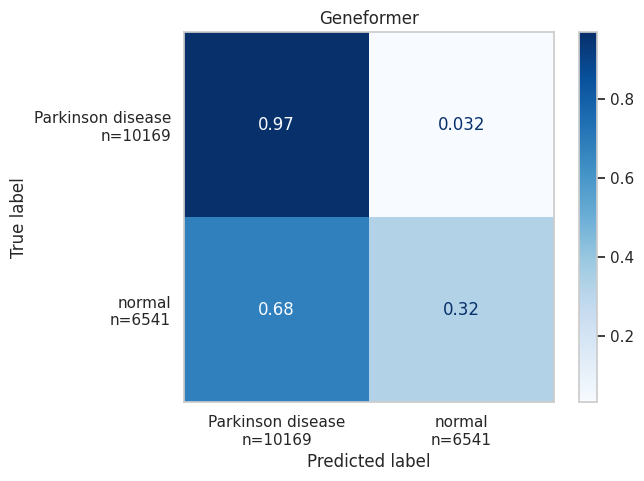

In [13]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix
)